In [1]:
import pandas as pd
from google.cloud import storage

def fetch_data(path):
  df = None
  try:
    df = pd.read_parquet(path)
    print("Read parquet successful")
    print(df.count())

    df.columns = df.columns.str.lower()
    df.rename(columns={'corr_elev_depth_spark': 'corr_elev_depth',
                      'avg_depth_spark': 'avg_depth'},
              inplace=True)

    display(df.head())
  except Exception as e:
    print(f"Error reading data from BigQuery using pandas_gbq: {e}")

  return df

BUCKET_NAME = "minex-1238"
SURVEY_SUMMARY = "processed/survey_summary.parquet"
DEPTH_ANOMALY= "processed/depth_anomaly.parquet"
BOUNDARY_DEPTH = "processed/boundary_depth.parquet"
REGIONAL_COVERAGE = "processed/regional_coverage.parquet"


df_summary = fetch_data(f"gs://{BUCKET_NAME}/{SURVEY_SUMMARY}")
df_anomaly = fetch_data(f"gs://{BUCKET_NAME}/{DEPTH_ANOMALY}")
df_boundary = fetch_data(f"gs://{BUCKET_NAME}/{BOUNDARY_DEPTH}")
df_regional = fetch_data(f"gs://{BUCKET_NAME}/{REGIONAL_COVERAGE}")

Read parquet successful
SURVEY_NAME      1435
VERTEX           1435
Avg_Depth        1435
Max_Elevation    1435
Depth_Rank       1435
dtype: int64


,survey_name,vertex,avg_depth,max_elevation,depth_rank
0,AusAEM1,6,52.683,878.900320,1
1,AusAEM1,30,51.746,868.714472,2
2,AusAEM1,10,51.510,885.690886,3
3,AusAEM1,4,50.652,877.202679,4
4,AusAEM1,1295,49.286,649.852899,5


Read parquet successful
VERTEX            2847
SURVEY_LINE       2847
longitude         2847
latitude          2847
depth             2847
cell_avg_depth    2847
cell_std_depth    2847
cell_points       2847
grid_x            2847
grid_y            2847
depth_anomaly     2847
dtype: int64


,vertex,survey_line,longitude,latitude,depth,cell_avg_depth,cell_std_depth,cell_points,grid_x,grid_y,depth_anomaly
0,17,2029001,138.605249,-20.183122,650.790,165.184,323.743,4,2497,77664,485.606
1,6,2029001,139.094116,-20.182584,650.962,166.792,322.803,4,3008,77671,484.170
2,10,2021002,138.869536,-18.718253,651.858,175.955,317.274,4,2753,79290,475.903
3,4,2023002,140.230123,-19.179539,644.327,172.139,314.793,4,4190,78791,472.188
4,14,2033001,138.998519,-20.909818,642.215,224.013,239.779,5,2918,76865,418.202


Read parquet successful
BOUNDARY_NAME         11
AGE_TYPE              12
vertex_count          12
avg_depth             12
depth_variability     12
centroid_longitude    12
centroid_latitude     12
dtype: int64


,boundary_name,age_type,vertex_count,avg_depth,depth_variability,centroid_longitude,centroid_latitude
0,PPR-W,Major_conductor,404,253.49,132.30,139.000898,-19.825497
1,None,Major_conductor,76,216.08,134.45,139.471518,-20.909884
2,PPR-W,WITHIN_Pre-Neoproterozoic,297,215.91,135.87,138.556312,-18.802322
3,PAL-B,BASE_Paleozoic_TOP_Pre-Neoproterozoic,1650,186.67,137.37,139.422321,-20.427526
4,PAL-W,WITHIN_Paleozoic,369,132.34,76.89,138.297094,-22.466091


Read parquet successful
region_x              231
region_y              231
n_points              231
avg_depth             231
high_conf_points      231
centroid_longitude    231
centroid_latitude     231
dtype: int64


,region_x,region_y,n_points,avg_depth,high_conf_points,centroid_longitude,centroid_latitude
0,14,160,1240,29.25,1139,143.136821,-17.820483
1,6,158,1048,46.32,771,139.312720,-18.695606
2,4,154,1019,29.41,879,138.347728,-20.565500
3,13,160,1010,47.26,777,142.664965,-17.826457
4,5,154,955,39.43,767,138.852482,-20.569566


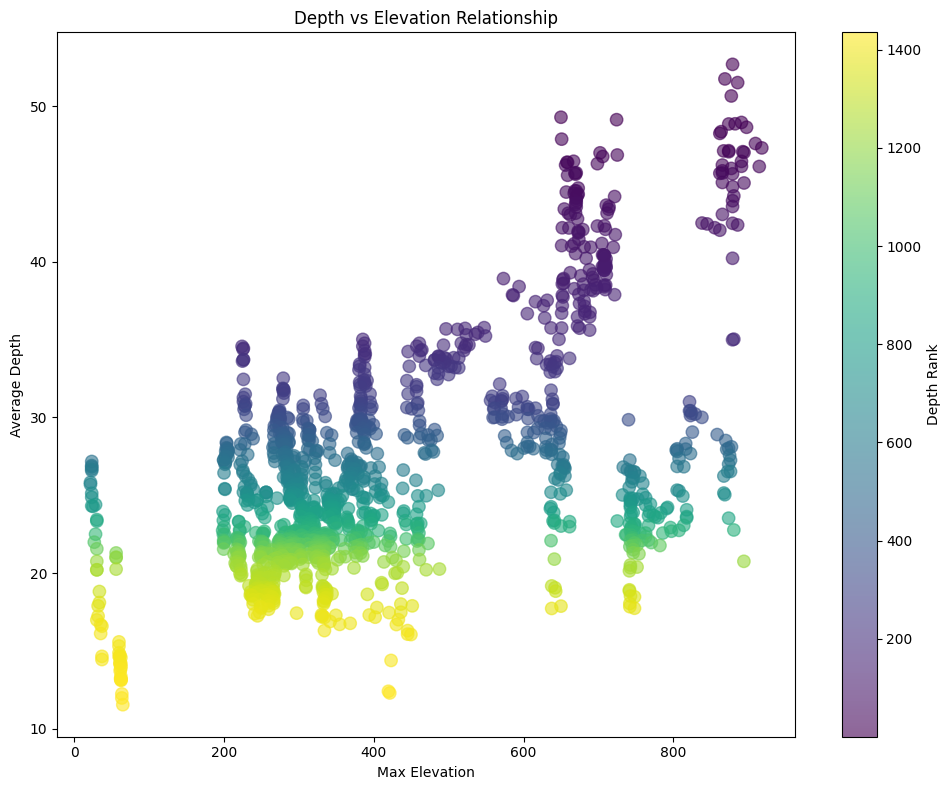

In [2]:
import matplotlib.pyplot as plt

# Convert 'avg_depth' to numeric, handling potential errors by coercing to NaN
df_summary['avg_depth'] = pd.to_numeric(df_summary['avg_depth'], errors='coerce')

plt.figure(figsize=(10, 8))
# Scatter plot: Max Elevation vs Average Depth
plt.scatter(df_summary['max_elevation'], df_summary['avg_depth'], alpha=0.6, s=80, c=df_summary['depth_rank'], cmap='viridis')
plt.colorbar(label='Depth Rank')
plt.xlabel('Max Elevation')
plt.ylabel('Average Depth')
plt.title('Depth vs Elevation Relationship')

plt.tight_layout()
plt.show()

In [3]:
!pip install cartopy

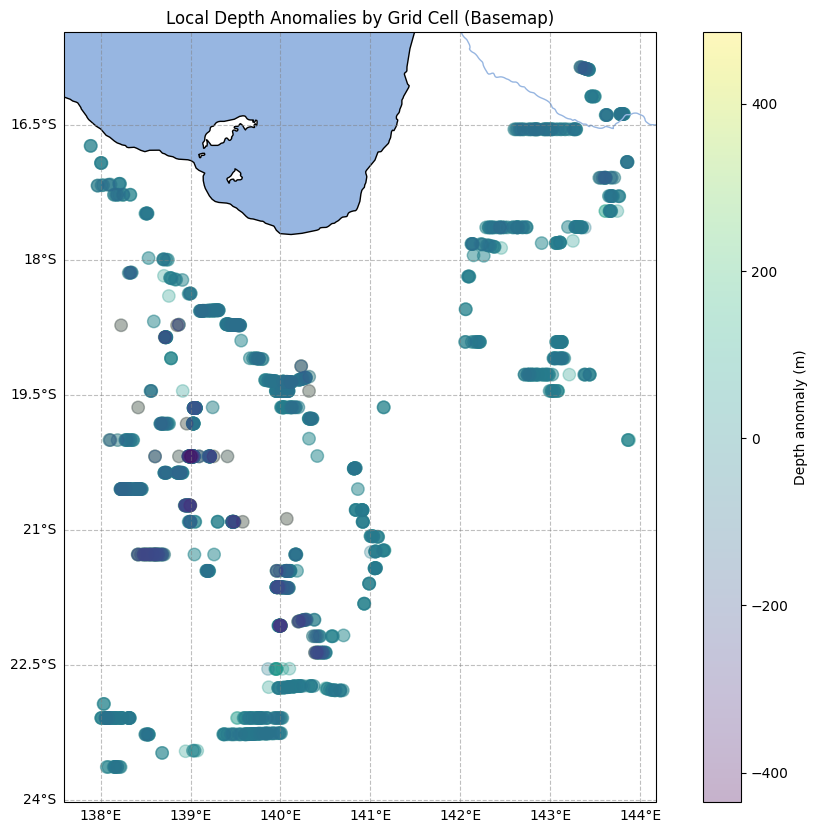

In [4]:
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.add_feature(cfeature.LAND, facecolor='white')
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)

gl = ax.gridlines(draw_labels=True, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

sc = ax.scatter(
    df_anomaly["longitude"],
    df_anomaly["latitude"],
    c=df_anomaly["depth_anomaly"],
    cmap="viridis",
    alpha=0.3,
    s=80,
    transform=ccrs.PlateCarree()
)

plt.colorbar(sc, ax=ax, label="Depth anomaly (m)")
ax.set_title("Local Depth Anomalies by Grid Cell (Basemap)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.show()

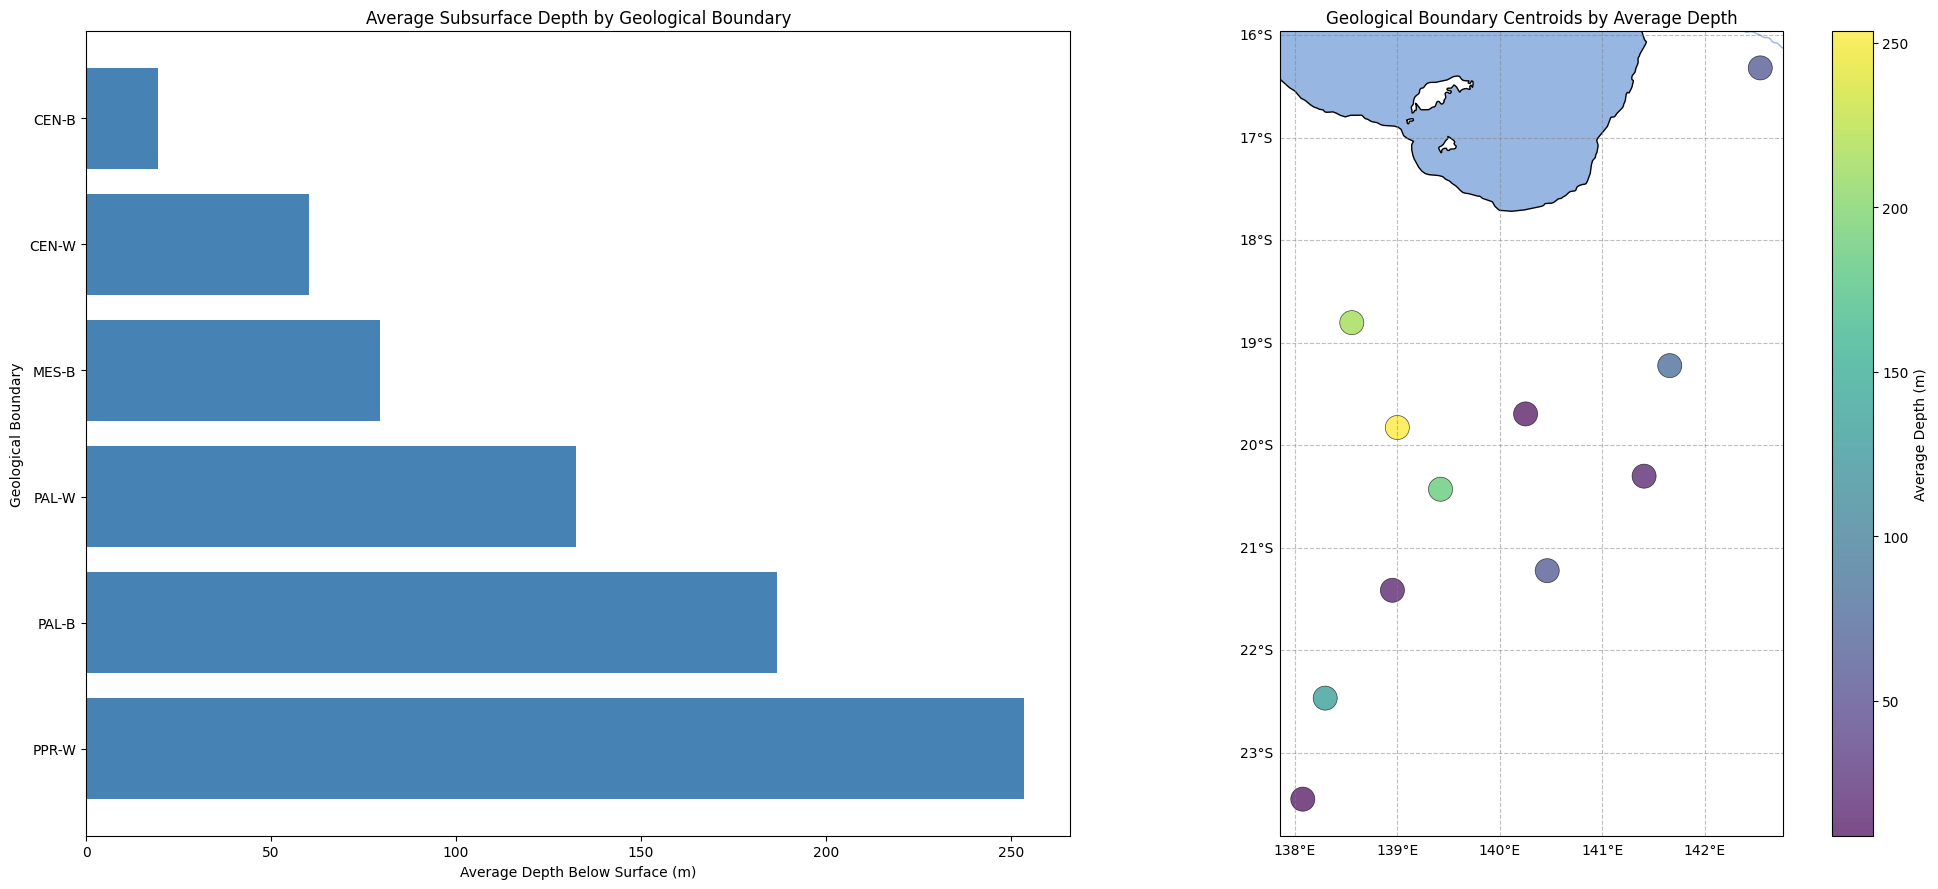

In [5]:
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

# Create figure with two subplots side by side
fig = plt.figure(figsize=(20, 9))

# Subplot 1: Horizontal bar chart (left)
ax1 = plt.subplot(1, 2, 1)
df_boundary_cleaned = df_boundary.dropna(subset=['boundary_name'])
ax1.barh(df_boundary_cleaned["boundary_name"], df_boundary_cleaned["avg_depth"], color="steelblue")
ax1.set_xlabel("Average Depth Below Surface (m)")
ax1.set_ylabel("Geological Boundary")
ax1.set_title("Average Subsurface Depth by Geological Boundary")

# Subplot 2: Map with centroids (right)
ax2 = plt.subplot(1, 2, 2, projection=ccrs.PlateCarree())

ax2.add_feature(cfeature.LAND, facecolor='white')
ax2.add_feature(cfeature.OCEAN)
ax2.add_feature(cfeature.COASTLINE)
ax2.add_feature(cfeature.BORDERS, linestyle=':')
ax2.add_feature(cfeature.LAKES, alpha=0.5)
ax2.add_feature(cfeature.RIVERS)

gl = ax2.gridlines(draw_labels=True, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Plot centroid points colored by average depth
sc = ax2.scatter(
    df_boundary_cleaned["centroid_longitude"],
    df_boundary_cleaned["centroid_latitude"],
    c=df_boundary_cleaned["avg_depth"],
    cmap="viridis",
    alpha=0.7,
    s=300,
    transform=ccrs.PlateCarree(),
    edgecolors='black',
    linewidths=0.5
)

plt.colorbar(sc, ax=ax2, label="Average Depth (m)")
ax2.set_title("Geological Boundary Centroids by Average Depth")
ax2.set_xlabel("Longitude")
ax2.set_ylabel("Latitude")

plt.tight_layout()
plt.show()

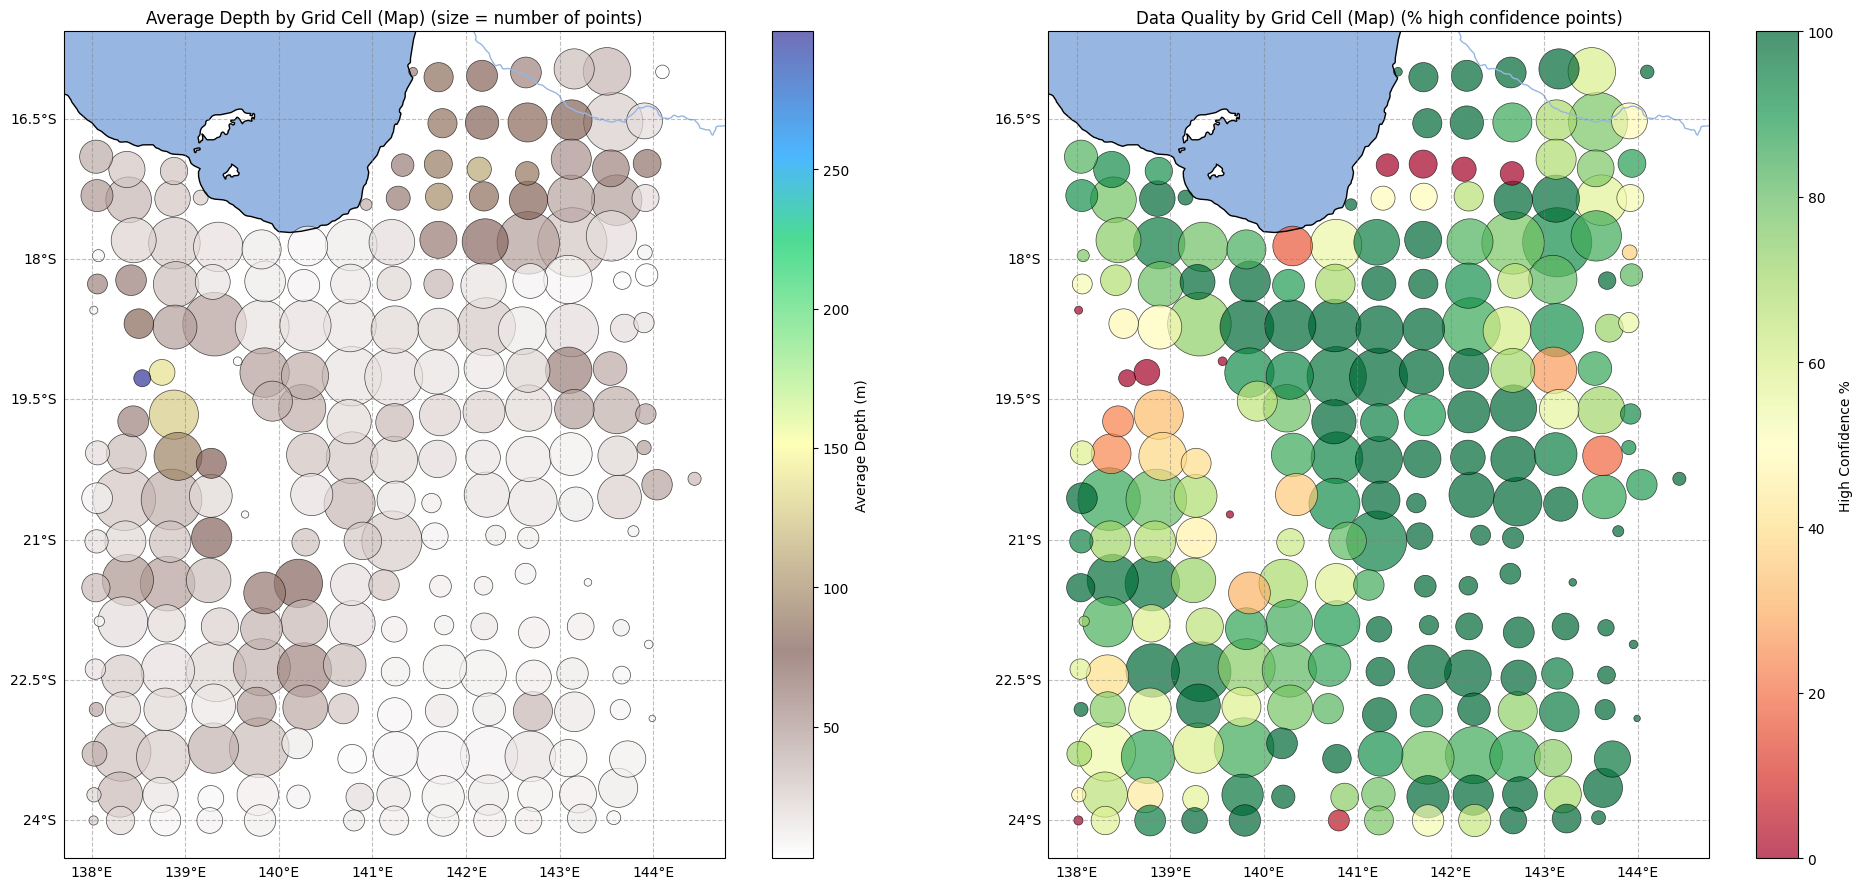

In [6]:
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import matplotlib.pyplot as plt

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot 1: Heatmap of average depth by grid cell on a map
ax1.add_feature(cfeature.LAND, facecolor='white')
ax1.add_feature(cfeature.OCEAN)
ax1.add_feature(cfeature.COASTLINE)
ax1.add_feature(cfeature.BORDERS, linestyle=':')
ax1.add_feature(cfeature.LAKES, alpha=0.5)
ax1.add_feature(cfeature.RIVERS)

gl1 = ax1.gridlines(draw_labels=True, color='gray', alpha=0.5, linestyle='--')
gl1.top_labels = False
gl1.right_labels = False

scatter1 = ax1.scatter(
    df_regional['centroid_longitude'],
    df_regional['centroid_latitude'],
    c=df_regional['avg_depth'],
    s=df_regional['n_points'] * 2,  # Size represents sample count
    cmap='terrain_r',
    alpha=0.7,
    edgecolors='black',
    linewidths=0.5,
    transform=ccrs.PlateCarree()
)
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.set_title('Average Depth by Grid Cell (Map) (size = number of points)')
plt.colorbar(scatter1, ax=ax1, label='Average Depth (m)')

# Plot 2: Data quality heatmap (high confidence ratio) on a map
df_regional['conf_ratio'] = df_regional['high_conf_points'] / df_regional['n_points'] * 100

ax2.add_feature(cfeature.LAND, facecolor='white')
ax2.add_feature(cfeature.OCEAN)
ax2.add_feature(cfeature.COASTLINE)
ax2.add_feature(cfeature.BORDERS, linestyle=':')
ax2.add_feature(cfeature.LAKES, alpha=0.5)
ax2.add_feature(cfeature.RIVERS)

gl2 = ax2.gridlines(draw_labels=True, color='gray', alpha=0.5, linestyle='--')
gl2.top_labels = False
gl2.right_labels = False

scatter2 = ax2.scatter(
    df_regional['centroid_longitude'],
    df_regional['centroid_latitude'],
    c=df_regional['conf_ratio'],
    s=df_regional['n_points'] * 2,
    cmap='RdYlGn',  # Red (low quality) to Green (high quality)
    alpha=0.7,
    edgecolors='black',
    linewidths=0.5,
    vmin=0,
    vmax=100,
    transform=ccrs.PlateCarree()
)
ax2.set_xlabel('Longitude')
ax2.set_ylabel('Latitude')
ax2.set_title('Data Quality by Grid Cell (Map) (% high confidence points)')
plt.colorbar(scatter2, ax=ax2, label='High Confidence %')

plt.tight_layout()
plt.show()